# Calculating Extreme Precipitation days using daily projections from Cal-Adapt API

In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt

----
# Download data
----

### Defining your area of interest

The `g` geometry parameter is used to download data for a point, line or polygon. Geometry can be written in various formats including WKT, GeoJSON, KML. The examples below use WKT (Well Known Text) format.

#### To get data for a grid cell ...

In [2]:
point = 'POINT(-121.4687 38.5938)'
params = {'g': point}

#### To get data for a user defined polygon ...

The `stat` parameter is used to spatially aggregation grid cell values intersected by the polygon/line geometry. Accepted values can be one of `mean`, `max`, `min`, `count`, `median`, `std`, `var`. If you don't provide the `stat` parameter the API will return an array of grid cell values.

You can create a new polygon using this [online WKT editor](https://arthur-e.github.io/Wicket/sandbox-gmaps3.html) or any GIS software.

In [3]:
polygon = 'POLYGON ((-123.35449 39.09596, -122.27783 39.09596, -122.27783 39.97712, -123.35449 39.97712, -123.35449 39.09596))' 
params = {'g': polygon, 'stat': 'mean'}

#### Or select a polygon from boundaries stored on Cal-Adapt

To use polygon geometry from Cal-Adapt API, it's a 2-step process

- Query a Cal-Adapt API boundary layer ([list of available boundaries](https://berkeley-gif.github.io/caladapt-docs/data-catalog.html#vector-data)) using a point to get the intersecting polygon
- Instead of passing the geometry using the `g` parameter, use the `ref` parameter to use geometry stored on server 

**Note: Requests might time out if the polygon is too large. Subsetting the daily data has been tested with polygons on scale of counties, census tracts, places and hydrounits. If you need data for a large boundary we reccomend downloading the daily rasters and processing the data locally.** 

In [4]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'
headers = {'ContentType': 'json'}

# Your point of interest
point = 'POINT(-121.4687 38.5938)'

# Name of boundary layer in API (Census Designated Place layer)
resource = 'place'

# Request url
url = api + '/' + resource + '/'
# Request params to find intersecting polygon
params = {'intersects': point, 'srs': 4326, 'simplify': .0001, 'precision': 4}
ref = ''
location = ''

# Get geometry
response = requests.get(url, params=params, headers=headers)
if response.ok:
    data = response.json()
    feature = data['features'][0]
    if (feature):
        ref = '/api/%s/%s/' % (resource, feature['id'])
        location = feature['properties']['name']
        print('ref =', ref)
        print('location =', location)
    else:
        print('Did not find any polygons that intersect your point')

params = {'ref': ref, 'stat': 'mean'}

ref = /api/place/97/
location = Sacramento


### Download timeseries

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are mm and projected data are in kg/m2/s.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given a slug and params
    - convert units to inches
    - return a new Pandas dataframe that contains all the data

In [5]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Request header
headers = {'ContentType': 'json'}

# Params
params = {'g': point}

def mm_to_inches(val):
    return val * 0.0393701

def kgm2s_to_inches(val):
    return  (val * 86400) * 0.0393701

def kgm2s_to_mm(val):
    return  (val * 86400)

In [6]:
def process_daily_data(slug, params):
    # Make request
    url = api + '/series/' + slug + '/rasters/'
    response = requests.get(url, params=params)
    
    # Get data
    if response.ok:
        print('Processing:', slug)
        json = response.json()
        data = json['results'][0]

        # Multiband raster data is returned by the API as a 3D array having a shape like (233376, 1, 1)
        # Flatten the 3D array into a 1D array
        values_arr = np.array(data['image'])
        values_arr = values_arr.flatten()

        # Get total number of values -> number of days
        length = len(values_arr)

        # Get start date of timeseries
        start_date = datetime.strptime(data['event'], '%Y-%m-%d')

        # Create new pandas dataframe and map each value in list to a date index
        df = pd.DataFrame(
            values_arr,
            index=pd.date_range(start_date, freq='1D', periods=length),
            columns=['value'],
        )

        # Convert units to Fahrenheit
        units = data['units']
        #if units == 'mm':
        #    df.value = df.value.apply(lambda x: mm_to_inches(x))
        if units == 'kg/m2/s':
            df.value = df.value.apply(lambda x: kgm2s_to_mm(x))
        else:
            pass
            
        # Add slug as a column
        df['series'] = slug.split('_')[2]
        
        # Add wateryear as a column
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['wateryear'] = np.where(df['month'] > 9, df['year'] + 1, df['year'])

    else:
        print('Failed to download:', slug)
            
    # Combine all the dataframes into one and return
    return df

In [7]:
def get_observed():
    # Create slug
    slug = 'pr_day_livneh'
    df = process_daily_data(slug, params)
    return df

### Download observed daily timeseries

In [8]:
observedDF = get_observed()
observedDF

Processing: pr_day_livneh


,value,series,year,month,wateryear
1950-01-01,0.555716,livneh,1950,1,1950
1950-01-02,0.990185,livneh,1950,1,1950
1950-01-03,0.000000,livneh,1950,1,1950
1950-01-04,0.000000,livneh,1950,1,1950
1950-01-05,0.000000,livneh,1950,1,1950
1950-01-06,0.000000,livneh,1950,1,1950
1950-01-07,7.082851,livneh,1950,1,1950
1950-01-08,5.789548,livneh,1950,1,1950
1950-01-09,1.111432,livneh,1950,1,1950
1950-01-10,16.267319,livneh,1950,1,1950


### Download projected daily timeseries

The projected daily timeseries are form 2006 - 2099/2100 and units are in kg/m2/s. You can easily modify the code to add/subtract models, scenarios, climate variables

In [9]:
def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['pr']
    period = ['day']
    models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5']
    #scenarios = ['rcp45', 'rcp85', 'historical]
    scenarios = ['rcp45', 'historical']
    zipped = itertools.product(climvar, period, models, scenarios)
    
    # Request parameters
    params = {'g': point}

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug, params)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [10]:
projectedDF = get_projections()
projectedDF

Processing: pr_day_CanESM2_rcp45
Processing: pr_day_CanESM2_historical
Processing: pr_day_CNRM-CM5_rcp45
Processing: pr_day_CNRM-CM5_historical
Processing: pr_day_HadGEM2-ES_rcp45
Processing: pr_day_HadGEM2-ES_historical
Processing: pr_day_MIROC5_rcp45
Processing: pr_day_MIROC5_historical


,value,series,year,month,wateryear
2006-01-01,0.000000,CanESM2,2006,1,2006
2006-01-02,0.000000,CanESM2,2006,1,2006
2006-01-03,0.000000,CanESM2,2006,1,2006
2006-01-04,0.095480,CanESM2,2006,1,2006
2006-01-05,0.304553,CanESM2,2006,1,2006
2006-01-06,0.000000,CanESM2,2006,1,2006
2006-01-07,0.000000,CanESM2,2006,1,2006
2006-01-08,0.000000,CanESM2,2006,1,2006
2006-01-09,0.000000,CanESM2,2006,1,2006
2006-01-10,16.372822,CanESM2,2006,1,2006


In [11]:
# Combine observed and projected data into a single dataframe
df = pd.concat([observedDF, projectedDF])
df

,value,series,year,month,wateryear
1950-01-01,0.555716,livneh,1950,1,1950
1950-01-02,0.990185,livneh,1950,1,1950
1950-01-03,0.000000,livneh,1950,1,1950
1950-01-04,0.000000,livneh,1950,1,1950
1950-01-05,0.000000,livneh,1950,1,1950
1950-01-06,0.000000,livneh,1950,1,1950
1950-01-07,7.082851,livneh,1950,1,1950
1950-01-08,5.789548,livneh,1950,1,1950
1950-01-09,1.111432,livneh,1950,1,1950
1950-01-10,16.267319,livneh,1950,1,1950


----
# Number of Extreme Precipitation Days
----

Using a baseline period of wateryears 1961 - 1990, calculate the 90th, 95th and 99th percentiles of daily precipitation values within a water year from the observed data. Count number of days with values above threshold.

In [12]:
# CALCULATE THRESHOLDS
# Filter data by baseline time period
baselineDF = df.loc[(df['wateryear'] >= 1961) & (df['wateryear'] <= 1990) & (df['series'] == 'livneh')]
threshold90 = baselineDF['value'].quantile(0.90, interpolation='linear')
threshold95 = baselineDF['value'].quantile(0.95, interpolation='linear')
threshold99 = baselineDF['value'].quantile(0.99, interpolation='linear')
print('90th Percentile Threshold is', round(threshold90, 2), 'mm/day')
print('95th Percentile Threshold is', round(threshold95, 2), 'mm/day')
print('99th Percentile Threshold is', round(threshold99, 2), 'mm/day')

90th Percentile Threshold is 2.72 mm/day
95th Percentile Threshold is 8.97 mm/day
99th Percentile Threshold is 24.14 mm/day


In [13]:
# SELECT 90TH PERCENTILE THRESHOLD
threshold = threshold90

In [14]:
# FILTER DAYS > THRESHOLD
days = pd.DataFrame(df[df.value > threshold])
days

,value,series,year,month,wateryear
1950-01-07,7.082851,livneh,1950,1,1950
1950-01-08,5.789548,livneh,1950,1,1950
1950-01-10,16.267319,livneh,1950,1,1950
1950-01-11,5.860276,livneh,1950,1,1950
1950-01-13,15.246822,livneh,1950,1,1950
1950-01-14,7.487008,livneh,1950,1,1950
1950-01-15,8.749998,livneh,1950,1,1950
1950-01-16,13.549362,livneh,1950,1,1950
1950-01-17,6.618071,livneh,1950,1,1950
1950-01-21,8.962181,livneh,1950,1,1950


In [15]:
# Group by wateryear and count number of days for each wateryear
days_count_by_year = days.groupby(['series', 'wateryear'])['value'].count()

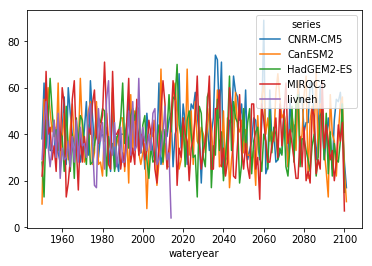

In [16]:
# Plot Number of Extreme Precipitation Days by Year
days_count_by_year.unstack('series').plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000202790446D8>,
      dtype=object)

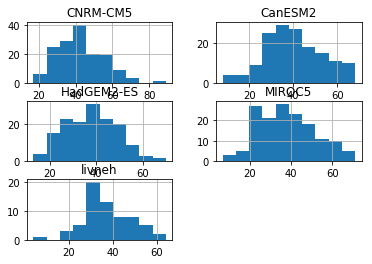

In [17]:
# Plot Histogram of Number of Extreme Precipitation Days by Year
days_count_by_year.unstack('series').hist()

----
# Extreme Value Analysis
----

In [60]:
baselineDF.to_csv('baseline.csv')

In [18]:
from scipy.stats.distributions import genextreme
from scipy.stats.distributions import genpareto

### Approach 1: Block Maxima/Annual Maximum Series (AMS)

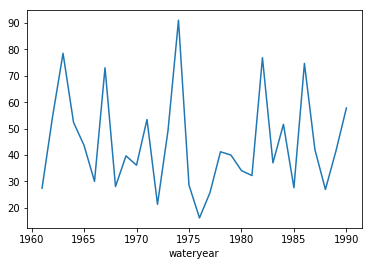

In [63]:
# Create Annual Maximum Series
baselineDF_max = baselineDF.groupby('wateryear').value.max()
data = list(baselineDF_max)
baselineDF_max.plot()

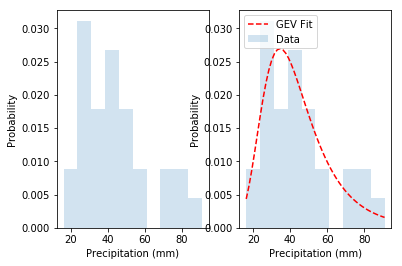

In [55]:
# Calculate GEV fit
gev_fit = genextreme.fit(data)

# GEV distribution parameters from fit
c, loc, scale = gev_fit

# Evenly spread x axis values for pdf plot
x = np.linspace(min(data), max(data))

# Calculate Probability Density Function
gev_pdf = genextreme.pdf(x, *gev_fit)

plt.subplot(1,2,1)
plt.hist(data, density=True, alpha=0.2, label='Data')  
plt.xlabel('Precipitation (mm)')
plt.ylabel('Probability')

plt.subplot(1,2,2)
plt.hist(data, density=True, alpha=0.2, label='Data')
plt.plot(x, gev_pdf, 'r--', label='GEV Fit')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Probability')
plt.legend(loc='upper left')
plt.show()

In [59]:
c, loc, scale

(-0.07499606867274433, 35.39082789501435, 13.692202391926685)

In [46]:
np.sum(gev_pdf)

0.6303064483380975